# Deep Learning On Ramp

## Forward pass + loss (numpy only)
**Goals** 
* Build intuition by coding an MLP without frameworks. 
* Lock in tensor shapes and loss definitions. 

### Task 1
1. Implement a 2-layer MLP (D -> H -> C) with ReLU and softmax (NumPy)
2. Write cross_entropy and softmax logits (stable version: shift by max)
3. Ad L2 regularization to the loss. 

**Checks**
* Unit test: feed a tiny batch with hand-computed outputs
* Verify that loss decreases with a single manual gradient step

In [27]:
import numpy as np
from onramp import ReLU, softmax, cross_entropy

class MLP:
    """A simple 2-layer Multi-Layer Perceptron (MLP) class."""

    def __init__(self, D, H, C, W1=None, b1=None, W2=None, b2=None, dtype=np.float32, seed=None) -> None: # noqa: PLR0913
        """Initialize the MLP with given dimensions and optional weights and biases.

        Args:
            D (_type_): Data input nodes. 
            H (_type_): Hidden nodes.
            C (_type_): Number of concents. One-hot encoded output. 
            W1 (_type_, optional): _description_. Defaults to None.
            b1 (_type_, optional): _description_. Defaults to None.
            W2 (_type_, optional): _description_. Defaults to None.
            b2 (_type_, optional): _description_. Defaults to None.

        """
        self.D, self.H, self.C = D, H, C
        self.dtype = dtype

        if seed is not None:
            rng = np.random.default_rng(seed)
            def randn(*s) -> np.ndarray:
                """Generate random numbers with the specified shape and dtype."""
                return rng.standard_normal(size=s).astype(dtype)
        else:
            def randn(*s) -> np.ndarray:
                """Generate random numbers with the specified shape and dtype."""
                return np.random.randn(*s).astype(dtype)

        # He init 
        self.W1 = W1.astype(dtype) if W1 is not None else randn(D, H) * np.sqrt(2.0 / D)
        self.b1 = b1.astype(dtype) if b1 is not None else np.zeros(H, dtype=dtype)
        self.W2 = W2.astype(dtype) if W2 is not None else randn(H, C) * np.sqrt(2.0 / H)
        self.b2 = b2.astype(dtype) if b2 is not None else np.zeros(C, dtype=dtype)


    def logits(self, X: np.ndarray) -> np.ndarray: # noqa: N803
        """Compute the logits (raw output) of the MLP.

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: The logits of the MLP.

        """
        X = X.astype(self.dtype, copy=False)  # Ensure input is in the correct dtype
        y1 = X @ self.W1 + self.b1 # (N, H)
        y1 = ReLU(y1) # (N, H)
        y2 = y1 @ self.W2 + self.b2 # (N, C)
        return y2


    def forward(self, X) -> np.ndarray:
        """Forward pass through the MLP.

        Args:
            X (_type_): _description_

        Returns:
            _type_: _description_

        """
        return softmax(self.logits(X))

    def loss(self, X:np.ndarray, y:np.ndarray, l2: float = 0.0) -> float:
        """Compute the cross-entropy loss with l2 regularization.

        Args:
            X (np.ndarray): Input data.
            y (np.ndarray): True labels.
            l2 (float, optional): L2 regularization strength. Defaults to 0.0.

        Returns:
            float: The computed loss value.

        """
        z = self.logits(X)
        ce = cross_entropy(z, y)
        l2_reg = 0.5*l2*(np.sum(self.W1**2) + np.sum(self.W2**2)) # L2 regularization term on weights
        return float(ce + l2_reg)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict class probabilities for the input data.

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: Predicted class probabilities.

        """
        return self.forward(X)/ np.sum(self.forward(X), axis=1, keepdims=True)
    

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for the input data.

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: Predicted class labels.

        """
        return np.argmax(self.predict_proba(X), axis=1)
    

    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Compute the accuracy of the model on the given data.

        Args:
            X (np.ndarray): Input data.
            y (np.ndarray): True labels.

        Returns:
            float: The accuracy of the model.

        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    

    def sgd_step(self, X:np.ndarray, y:np.ndarray, lr:float = 1e-2, l2:float = 0.0) -> float: 
        """Perform a single SGD step on a batch (X,y).

        Args:
            X (np.ndarray): Data
            y (np.ndarray): target. Can be (N,) integer labels or (N,C) one hot
            lr (float, optional): _description_. Defaults to 1e-2.
            l2 (float, optional): _description_. Defaults to 0.0.

        Returns: current loss

        """
        N = X.shape[0]
        C = self.C 

        # --- Forward ---
        a1 = X@ self.W1 + self.b1
        h = ReLU(a1)
        z = h @ self.W2 + self.b2

        # stable softmax
        z_shift = z - z.max(axis=1, keepdims=True)
        expz = np.exp(z_shift)
        p = expz/expz.sum(axis=1, keepdims=True)

        # --- Prepare labels ---
        if y.ndim == 1: 
            y_onehot = np.eye(C, dtype=p.dtype)[y] # (N, C)
        elif y.ndim == 2 and y.shape == p.shape: # noqa: PLR2004
            y_onehot = y
        else: 
            raise ValueError("y most be (N,) ints or (N, C) one-hot.")

        # --- Backprop ---
        dz = (p - y_onehot) / N  # <--- softmax derivative? 

        dW2 = h.T @ dz
        db2 = dz.sum(axis=0)

        dh = dz @ self.W2.T
        da1 = dh * (a1 > 0)

        dW1 = X.T @ da1
        db1 = da1.sum(axis=0)

        if l2 > 0.0: 
            dW2 += l2*self.W2
            dW1 += l2*self.W1


        # --- Param update ----
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

        return self.loss(X, y, l2=l2)


Tests:

In [28]:
mlp = MLP(D=2, H=10, C=2, seed=42)
X = np.array([[1,0], [0,1], [1,1], [0,0]])
y = np.array([[1,0], [1,0], [0,1], [0,1]])

L2 = 0.0
LR = 0.5

losses = []
for _ in range(200):
    loss = mlp.loss(X,y,l2=L2)
    losses.append(loss)
    mlp.sgd_step(X,y, lr=LR, l2=L2)

Text(0, 0.5, 'Loss')

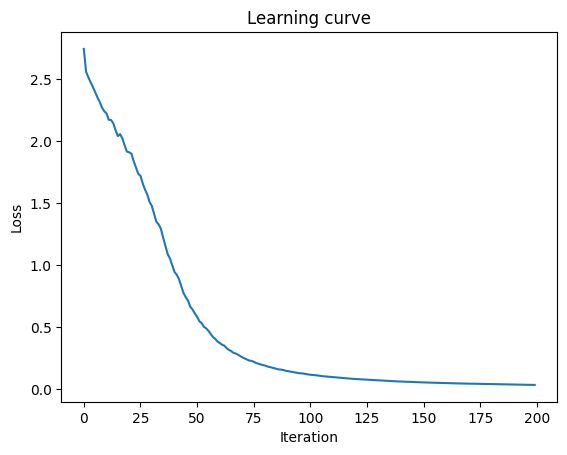

In [25]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")


In [29]:
mlp.predict_proba(X)

array([[0.98849299, 0.01150701],
       [0.99214326, 0.00785674],
       [0.0028644 , 0.9971356 ],
       [0.00999406, 0.99000594]])

-> Finite difference check backprop
-> log-sum-exp trick (review)
-> Learn Rate finder - picks the largest LR before loss spikes, then train with +/- 1/3 of that and add decay.
-> Early flattening of the learning curve - L2 too high or a capacity issue.
-> No oscillation in the learning curve - LR isn't too high
-> Keeps falling past 0.1 -> not capacity limited. 

## Dataloader

Desiderata:
* Work with any dataset implementing __len__ and __getitem(i)
* Deterministic shuffling. Reproducible via seed and per-epoch control, no data leakage
* Batching controls: batch_size, drop_last
* Collation: can stack NumPy arrays, recursibely handle tuples/lists/dicts.
* Length semantics: len(dataloader) returns number of batches
* Memory-friendly: no data copying
* Composability: ? 
* Per-epoch reseeding
* Clear errors: shape/length mismatches fail loudly
* Samplers, prefetch...

In [46]:
from typing import Any, Callable, List, Sequence, Union, Tuple, Dict, Optional
import numpy as np

class DatasetProtocol:
    """Any dataset with __len__ and __getitem__ is acceptable for the dataloader."""

    def __len__(self) -> int: ... # noqa: D105, Convention in typing is to uses ellipsis (...) 
    def __getitem__(self, idx: int) -> Any: ... # noqa: ANN401, D105

def _default_collate(batch: List[Any]) -> Any:
    """Collate: to take multiple individual samples from the dataset and
    assemble them in to a single batch in the format the model expects.
    Stacks numpy arrays along a new first dimension when shapes match.
    Recursively handles tuples, lists and dicts.

    Args:
        batch (List[Any]): List of samples from the dataset.

    Returns:
        Any: Collated batch, which can be a numpy array, tuple, list

    """ # noqa: D205
    elem = batch[0]

    # numpy arrays
    if isinstance(elem, np.ndarray):
        # Verify shapes match
        shapes = [x.shape for x in batch]
        if not all(s == shapes[0] for s in shapes):
            raise ValueError(f"Array shapes differ in batch: {shapes}")
        return np.stack(batch, axis=0)

    # numbers
    if isinstance(elem, (int, float, np.integer, np.floating)):
        return np.array(batch)

    # tuples
    if isinstance(elem, tuple): 
        transposed = list(zip(*batch))
        return tuple(_default_collate(list(x)) for x in transposed)

    # lists
    if isinstance(elem, list):
        transposed = list(zip(*batch))
        return [_default_collate(list(x)) for x in transposed]

    # dicts
    if isinstance(elem, dict):
        keys = elem.keys()
        if not all(d.keys() == keys for d in batch):
            raise ValueError("All dict samples must have the same keys.") #noqa:TRY003, EM101
        return {k: _default_collate([d[k] for d in batch]) for k in keys}

    return batch  # If no known type, return as is


class Dataloader: 
    """Training data management class."""

    def __init__(self,
                 dataset: DatasetProtocol,
                 batch_size: int = 32,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 collate_fn: Optional[Callable[[List[Any]], Any]] = None,
                 seed: Optional[int] = 42,
                 indices: Optional[Sequence[int]] = None,
                 ):
        if batch_size <= 0:
             raise ValueError("batch size must be positive")
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last 
        self.collate_fn = collate_fn or _default_collate
        self.base_seed = seed
        self.epoch = 0

        n = len(dataset)
        if indices is None:
            self.indices = np.arange(n, dtype=int)
        else:
            self.indices = np.array(indices, dtype=np.int64)
            if np.any(self.indices < 0) or np.any(self.indices >= n):
                raise ValueError("indices out of bouds")

        self._compute_num_batches()


    def _compute_num_batches(self):
        N = len(self.indices)
        if self.drop_last:
            self.num_batches = N // self.batch_size
        else: 
            self.num_batches = (N + self.base_seed - 1) // self.batch_size


    def set_epoch(self, epoch:int):
        """Set curretnt epoch (affects shuffle RNG state deterministically.)"""
        self.epoch = int(epoch)

    def __len__(self) -> int:
        return self.num_batches

    def __iter__(self):
        order = self.indices.copy() 
        if self.shuffle:
            rng = np.random.default_rng(None if self.base_seed else self.base_seed + self.epoch)
            rng.shuffle(order)

        N = len(order)
        bs = self.batch_size
        limit = (N // bs) * bs if self.drop_last else N

        for start in range(0, limit, bs):
            end = min(start + bs, N)
            batch_indices = order[start:end].tolist() 
            batch_samples = [self.dataset[i] for i in batch_indices]
            yield self.collate_fn(batch_samples)

In [47]:
class ArrayDataset(DatasetProtocol):
    """Simple dataset that wraps a numpy array."""

    def __init__(self, X: np.ndarray, y: np.ndarray): 
        if len(X) != len(y):
            raise ValueError("X and y must have the same length.")
        self.X = X
        self.y = y

    def __len__(self) -> int: return len(self.X)
    def __getitem__(self, i) -> Tuple[np.ndarray, np.ndarray]:
        return (self.X[i], self.y[i])
    
X = np.arange(20).reshape(10, 2).astype(np.float32)
y = (np.sum(X, axis=1) > 10).astype(np.int64)  # Binary classification

ds = ArrayDataset(X, y)
loader = Dataloader(ds, batch_size=4, shuffle=True, drop_last=False, seed=42)

for epoch in range(2):
    loader.set_epoch(epoch)
    print(f"\n[Dataloader] Epoch {epoch}")
    for batch in loader: 
        xb, yb = batch
        print(f"[Dataloader]\n[Batch] X: \n {xb} \n[Batch] y:\n {yb} \n")




[Dataloader] Epoch 0
[Dataloader]
[Batch] X: 
 [[ 4.  5.]
 [12. 13.]
 [ 6.  7.]
 [10. 11.]] 
[Batch] y:
 [0 1 1 1] 

[Dataloader]
[Batch] X: 
 [[ 2.  3.]
 [ 0.  1.]
 [18. 19.]
 [ 8.  9.]] 
[Batch] y:
 [0 0 1 1] 

[Dataloader]
[Batch] X: 
 [[14. 15.]
 [16. 17.]] 
[Batch] y:
 [1 1] 


[Dataloader] Epoch 1
[Dataloader]
[Batch] X: 
 [[ 0.  1.]
 [18. 19.]
 [12. 13.]
 [14. 15.]] 
[Batch] y:
 [0 1 1 1] 

[Dataloader]
[Batch] X: 
 [[ 2.  3.]
 [16. 17.]
 [ 8.  9.]
 [ 6.  7.]] 
[Batch] y:
 [0 1 1 1] 

[Dataloader]
[Batch] X: 
 [[10. 11.]
 [ 4.  5.]] 
[Batch] y:
 [1 0] 



## Optimizers

### SGD
At each training step, given parameters $\theta$ (weights), gradient $g = \nabla_\theta L(\theta)$ and a learning rate $\eta$, take: 

$$ \theta \leftarrow \theta - \eta g $$

**Real implementation:** 
* learning rate schedule (allow lr to decay over epochs)
* momentum: accumulate a velocity term to accelerate convergence
* Nesterov momentum: "look ahead" before aplying momentum
* weight decay
* clipping 
* batching 

In [67]:
class SGD:
    """Stochastic Gradient Descent optimizer."""

    def __init__(self, params, lr=0.01) -> None:# noqa: ANN001
        """Initialize the SGD optimizer.

        Args:
            params: list of dicts with {"value": np.ndarray, "grad": np.ndarray}
            lr: learning rate

        """
        self.params = params
        self.lr = lr

    def step(self) -> None:
        """Update parameters in-place."""
        for param in self.params:
            if param["grad"] is None:
                continue # Skip if no gradient was computed.
            param["value"] -= self.lr * param["grad"]

    def zero_grad(self) -> None:
        """Reset gradients to zero (important for next step)."""
        for param in self.params:
            if param["grad"] is not None:
                param["grad"].fill(0)

### Momentum 

Momentum beats on problems with strong curvature anisotropy (ravines/ill conditioning) or saddle-heavy landscapes.

In [74]:
import numpy as np
from typing import Any, Callable, List, Sequence, Union, Tuple, Dict, Optional

class MomentumSGD:
    """Stochastic Gradient Descent optimizer with momentum (and optional Nesterov)."""

    def __init__(self, 
                 params:List[Dict[str, np.ndarray]], 
                 lr=0.01,
                 momentum: float = 0.9, 
                 nesterov: bool = True,
                 dampening:float = 0.0,
                 weight_decay: float = 0.0, 
                 maximize: bool = False) -> None: 
        """Initialize the Momentum SGD optimizer.

        Args:
            params: list of dicts with {"value": np.ndarray, "grad": np.ndarray}
            lr: learning rate

        """
        if not (0.0 <= momentum < 1.0):
            raise ValueError("Momentum must be in [0.0, 1.0).") # noqa: EM101, TRY003
        if not (0.0 <= dampening < 1.0):
            raise ValueError("Dampening must be in [0.0, 1.0).") # noqa: EM101, TRY003
        if weight_decay < 0.0:
            raise ValueError("Weight decay must be non-negative.") # noqa: EM101, TRY003

        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.nesterov = nesterov
        self.dampening = dampening
        self.weight_decay = weight_decay
        self.maximize = maximize

        # Per-parameter momentum buffers
        self._vel: List[Optional[np.ndarray]] = [None] * len(params)

    def step(self) -> None:
        """Update parameters in-place."""
        sign = -1.0 if not self.maximize else 1.0

        for i, p in enumerate(self.params):
            g = p["grad"]
            if g is None:
                continue

            # L2 weight decay (coupled )
            if self.weight_decay > 0.0:
                g += self.weight_decay * p["value"]

            # Init / update velocity buffer
            v = self._vel[i]
            if v is None:
                v = np.zeros_like(p["value"])

            v = self.momentum * v + (1.0 - self.dampening) * g
            g_eff = g + self.momentum * v if self.nesterov else v

            # Update parameter
            p['value'] -= sign * self.lr * g_eff
            self._vel[i] = v


    def zero_grad(self) -> None:
        """Reset gradients to zero (important for next step)."""
        for param in self.params:
            if param["grad"] is not None:
                param["grad"].fill(0)

In [81]:
from copy import deepcopy

def rosenbrock(xy):
    x,y = xy
    return (1-x)**2 + 100*(y - x**2)**2

def rosen_grad(xy):
    x,y = xy
    dfdx = -2*(1-x) - 400*x*(y - x**2)
    dfdy = 200*(y - x**2)
    return np.array([dfdx, dfdy])

def run_optimizer(opt, x0, grad_fn, max_steps=20000, tol=1e-6):
    """Run the optimizer on the Rosenbrock function.

    Args:
        opt: Optimizer instance (e.g., SGD, MomentumSGD).
        x0: Initial point as a numpy array.
        grad_fn: Gradient function to compute gradients.
        max_steps: Maximum number of optimization steps.
        tol: Tolerance for stopping criterion.

    Returns:
        int: Number of steps taken until convergence or max_steps reached.

    """
    loss = []
    x = opt.params[0]["value"]
    x[:] = x0
    for t in range(max_steps):
        g = grad_fn(x)
        opt.params[0]["grad"][:] = g
        opt.step()
        opt.zero_grad()
        loss.append(rosenbrock(x))
        if np.linalg.norm(g) < tol:
            return t+1
    return loss

# Example: Rosenbrock
x_param = {"value": np.array([-1.2, 1.0], dtype=float), "grad": np.zeros(2)}
loss_sgd = run_optimizer(SGD([x_param.copy()], lr=1e-3), np.array([-1.2,1.0]), rosen_grad)
loss_mom = run_optimizer(MomentumSGD([x_param.copy()], lr=1e-3, momentum=0.9),
                          np.array([-1.2,1.0]), rosen_grad)


/var/folders/wm/3n4z6f854gjfgn3qgq832k140000gn/T/ipykernel_75446/2520446730.py:5: RuntimeWarning: overflow encountered in scalar power
  return (1-x)**2 + 100*(y - x**2)**2
/var/folders/wm/3n4z6f854gjfgn3qgq832k140000gn/T/ipykernel_75446/2520446730.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dfdx = -2*(1-x) - 400*x*(y - x**2)
/Users/vojtahavlicek/onramp/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2791: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)


Text(0.5, 1.0, 'SGD vs Momentum Loss')

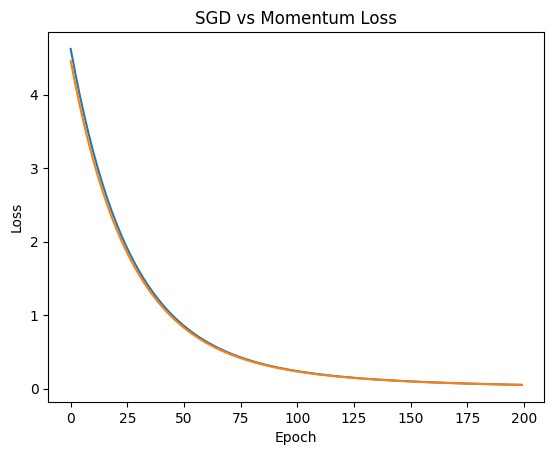

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_sgd, label="SGD")
ax.plot(loss_mom, label="Momentum")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("SGD vs Momentum Loss")

### Adam 
Adagrad, RMSprop, Adam scale learning rate per parameter based on the past gradients. 
### AdamW 
Decoupled/updated l2-regularization of weights

In [79]:
import numpy as np

class AdamW:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
        self.m = [np.zeros_like(p["value"]) for p in params]
        self.v = [np.zeros_like(p["value"]) for p in params]

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            g = p["grad"]
            if g is None: continue

            # moment estimates
            self.m[i] = self.beta1 * self.m[i] + (1-self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1-self.beta2) * (g*g)

            # bias correction
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # update: Adam step + decoupled weight decay
            p["value"] -= self.lr * (m_hat / (np.sqrt(v_hat) + self.eps) + self.weight_decay * p["value"])

    def zero_grad(self):
        for p in self.params:
            if p["grad"] is not None:
                p["grad"].fill(0.0)


In [ ]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")